# Industrial Applications of Artificial Intelligence

### This notebook will give an overview on the datasets and algorithms that will be used for the first hand-in regarding the primary sector wind in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Agriculture is a very important sector of each country and humanity still highly relies on agriculture to generate food. For getting the best yield out of the crop farmers highly depend on monitoring and suggestions based on the crops along with external factors. The ultimate aim is to reduce the losses by providing rich recommendations & insights about the crops. But before providing any suggestions, the crop needs to be classified. Machine Learning can help with this. In the following we want to explore how the classification behaves with different sizes of data (original and original + augmented) and models.

In [137]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization, Reshape, UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir, getcwd, system
from sklearn.metrics import multilabel_confusion_matrix
import os
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.image as mpimg
from sklearn.preprocessing import OneHotEncoder
from numpy import asarray
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn import svm
from sklearn.decomposition import PCA
from skimage.io import imread, imshow

## I. Import Data

The dataset can be found on kaggle unter the following [url](https://www.kaggle.com/datasets/aman2000jaiswal/agriculture-crop-images). The original imageset in the folder crop images contains 40 pictures for 5 different sorts of crop, in particular maize, wheate, jute, rice and sugarcane. This base set is complemented by a second file set including 160 augmented images per class. The augmentation methods consist of a horizontal flip, a rotation, a horizontal shift and a vertical shift. The folder some more images contains 10 further images per class that will be used as validation set. On top of that, we have already a given test set in the folder test_crop_image. We will not change the amount of the validation set throughout the experiments, to be able to capture the effect of the augmented data and make it comparable.

In a first step we want to load the data. We will use a predefined function for that, where we can directly specifiy the labels and the image size.

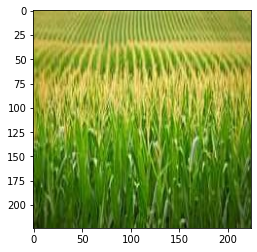

In [2]:
#Load on example picture of maize
path = "../../src/data/Abgabe_1_Crop_images/crop_images/maize/maize001a.jpeg"
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

In [3]:
#lets explore the image a bit
print("The image is stored in an", type(img), "of dimensions", img.shape)
print("The maximum value in the array is", np.max(img))
print("The minimum value is", np.min(img))

The image is stored in an <class 'numpy.ndarray'> of dimensions (224, 224, 3)
The maximum value in the array is 255
The minimum value is 0


We can clearly see that our pictures already have the dimensions 224,224,3. So, let's load the whole dataset.

In [4]:
def load_images(dir_path, labels, X, y, image_size):
    for s in labels:
        comp_path = dir_path+s+"/"
        list_of_images = os.listdir(comp_path)
        for i in list_of_images:
            img = image.load_img(dir_path+s+"/"+i, target_size=image_size)
            img = image.img_to_array(img)
            img = img/255
            X.append(img)
            y.append(s)

    X = np.array(X)
    return X, y

In [175]:
X_train = []
y_train = []
dir_path ='../../src/data/Abgabe_1_Crop_images/crop_images/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_train, y_train = load_images(dir_path, labels, X_train, y_train, image_size)

X_val = []
y_val = []
dir_path_val = '../../src/data/Abgabe_1_Crop_images/some_more_images/'
labels_val = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_val, y_val = load_images(dir_path_val, labels_val, X_val, y_val, image_size)

print("I'm done!")

I'm done!


# II. First Baselines

In order to get some baselines to measure how good further models perform, we will make use of a classical SVM and a stupid use of a pretrained VGG classifier.

## SVM

For the SVM we will flatten the arrays first.

In [6]:
X_train_flat = [x.flatten() for x in X_train]
X_val_flat = [x.flatten() for x in X_val]

In [7]:
# We make use of a predefined SVM standard implementation of the exercise
def svm_model(X_train, y_train, X_val, y_val):
    model = svm.SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    return model

In [8]:
model = svm_model(X_train_flat, y_train, X_val_flat, y_val)

Accuracy: 0.28
[[3 1 1 5 0]
 [1 1 1 7 0]
 [1 2 1 5 1]
 [0 1 2 7 0]
 [0 3 4 1 2]]


We can clearly see that the model has a clear tendency to predict sugarcane and is cleary not good yet. So lets try to extend our data by using the augmented data as well.

In [176]:
X_train_augmented = []
y_train_augmented = []
dir_path ='../../src/data/Abgabe_1_Crop_images/kag2/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_train_augmented, y_train_augmented = load_images(dir_path, labels, X_train_augmented, y_train_augmented, image_size)

print("I'm done!")

I'm done!


In [177]:
#Construct a new training set containing both normal and augmetented 
X_train_enhanced = np.concatenate((X_train, X_train_augmented))
y_train_enhanced = np.concatenate((y_train, y_train_augmented))

In [11]:
print(len(X_train_enhanced))
print(len(y_train_enhanced))

1005
1005


In [12]:
#flatten the values again
X_train_flat = [x.flatten() for x in X_train_enhanced]
X_val_flat = [x.flatten() for x in X_val]

In [13]:
model = svm_model(X_train_flat, y_train_enhanced, X_val_flat, y_val)

Accuracy: 0.38
[[4 1 2 3 0]
 [3 2 1 4 0]
 [1 5 2 1 1]
 [0 2 1 7 0]
 [0 2 3 1 4]]


We see that this improves our model, but we are still far from a good result. In order to not only focus on normal models, we want to get a neural network baseline as well and therefor make use of a pretrained VGG implementation that is based on a convolutional neural network architecture..

## VGG

To be able to use the labels in a neural network, we need to one hot encode them first.

In [ ]:
# function to evaluate the model
def evaluate_model(m, X, y):
    y_pred = m.predict(X)
    predicted_classes = np.argmax(y_pred,axis=1)
    
    predictions = []
    for i in predicted_classes:
        if i == 0:
            predictions.append("jute")
        elif i == 1:
            predictions.append("maize")
        elif i == 2:
            predictions.append("rice")
        elif i == 3:
            predictions.append("sugarcane")
        else:
            predictions.append("wheat")
    print("Accuracy:",metrics.accuracy_score(y, predictions))
    print(confusion_matrix(y, predictions))

In [170]:
# one hot encode the labels for without augmented and with augmented
y_train_res = asarray(y_train).reshape(-1, 1)
y_val_res = asarray(y_val).reshape(-1, 1)
y_train_res_enhanced = asarray(y_train_enhanced).reshape(-1, 1)


oh_enc = OneHotEncoder(sparse=False)

y_train_onehot = oh_enc.fit_transform(y_train_res)
y_val_onehot = oh_enc.transform(y_val_res)
y_train_onehot_augmented_enhanced = oh_enc.fit_transform(y_train_res_enhanced)
y_val_onehot_augmented = oh_enc.transform(y_val_res)

print("Original Label:", y_train[0])
print("One-Hot Label:", y_train_onehot[0])

Original Label: jute
One-Hot Label: [1. 0. 0. 0. 0.]


Initialise a first model.

In [171]:
# use the variant withput further training and Leave out the last fully connected layer
vgg16_without_top_layer = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg16_without_top_layer.trainable = False


# Flatten the output layer to 1 dimension to be able to build on top of it
flat = Flatten()(vgg16_without_top_layer.layers[-1].output)
dense1 = Dense(256, activation="relu")(flat)
#adjust the ouptut layer to 5 clases
output = Dense(5, activation="softmax")(dense1)

model_transfer_learning = Model(inputs = vgg16_without_top_layer.inputs, outputs = output)
model_transfer_learning.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [172]:
#compile the model
model_transfer_learning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [17]:
#small batch size for our initial set
model_transfer_learning_history = model_transfer_learning.fit(X_train, y_train_onehot, batch_size=8,epochs=15,verbose=1,validation_data=(X_val, y_val_onehot), callbacks=[callback])

Epoch 1/15
26/26 [==============================] - 84s 3s/step - loss: 2.6009 - accuracy: 0.3134 - val_loss: 2.3674 - val_accuracy: 0.3400
Epoch 2/15
26/26 [==============================] - 86s 3s/step - loss: 0.9047 - accuracy: 0.6567 - val_loss: 1.2924 - val_accuracy: 0.5200
Epoch 3/15
26/26 [==============================] - 93s 4s/step - loss: 0.2801 - accuracy: 0.9254 - val_loss: 1.2094 - val_accuracy: 0.5800
Epoch 4/15
26/26 [==============================] - 89s 3s/step - loss: 0.2341 - accuracy: 0.9303 - val_loss: 1.6429 - val_accuracy: 0.4200
Epoch 5/15
26/26 [==============================] - 89s 3s/step - loss: 0.1591 - accuracy: 0.9502 - val_loss: 1.3357 - val_accuracy: 0.5600
Epoch 6/15
26/26 [==============================] - 101s 4s/step - loss: 0.0836 - accuracy: 1.0000 - val_loss: 1.2485 - val_accuracy: 0.5600


In [179]:
#higher batch size for our augmented set
model_transfer_learning_history = model_transfer_learning.fit(X_train_enhanced, y_train_onehot_augmented_enhanced, batch_size=32,epochs=15,verbose=1,validation_data=(X_val, y_val_onehot_augmented), callbacks=[callback])

Epoch 1/15
32/32 [==============================] - 527s 16s/step - loss: 1.2564 - accuracy: 0.5831 - val_loss: 1.1941 - val_accuracy: 0.4400
Epoch 2/15
32/32 [==============================] - 485s 15s/step - loss: 0.2065 - accuracy: 0.9493 - val_loss: 1.1589 - val_accuracy: 0.6200
Epoch 3/15
32/32 [==============================] - 485s 15s/step - loss: 0.0815 - accuracy: 0.9881 - val_loss: 1.2565 - val_accuracy: 0.5600
Epoch 4/15
32/32 [==============================] - 411s 13s/step - loss: 0.0338 - accuracy: 0.9990 - val_loss: 1.2801 - val_accuracy: 0.5800
Epoch 5/15
32/32 [==============================] - 432s 14s/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 1.2664 - val_accuracy: 0.5200


In [180]:
model_transfer_learning.save("Transfer_vgg16_baseline_v1.h5")
model = load_model("Transfer_vgg16_baseline_v1.h5")

In [181]:
evaluate_model(model, X_val, y_val)

Accuracy: 0.62
[[8 0 2 0 0]
 [1 8 1 0 0]
 [0 5 5 0 0]
 [0 1 6 3 0]
 [0 1 1 1 7]]


We can clearly see that the neural networks are far better in capturing the pictures than the SVM's. Even the smaller version beats the augmented SVM version. So letts first try to increase the performance of the SVM. 

## III. SVM extensive training

### III.I Smaller Dataset

We will first us PCA and autoencoders reduce the dimensions and extract only meaningful features.

In [19]:
# first flatten the data again
X_train_flat = [x.flatten() for x in X_train]
X_val_flat = [x.flatten() for x in X_val]

In [20]:
#we will use PCA to extract the features that explain at least 80 percent of the variance
pca = PCA(n_components=0.9, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_flat)
#use pca also on validation set, but withput further fitting
X_val_pca = pca.transform(X_val_flat)

In [21]:
print(len(X_train_pca[0]))
print(len(X_train[0]))

101
224


In [22]:
model = svm_model(X_train_pca, y_train, X_val_pca, y_val)

Accuracy: 0.34
[[4 1 1 4 0]
 [1 1 1 7 0]
 [1 0 1 7 1]
 [0 0 2 8 0]
 [0 1 4 2 3]]


We were able to reduce the feature size by more than half, while still keeping good results only by pca. Lets extract features with an autoencoder aswell and use them as further input.

### Autoencoder

We will use the version of the network presented in the exercise, as the dimensions fit perfectly. The autoencoder gets the same data as input and output, cause we want to learn a meaningful representation of the data.

In [23]:
autoencoder = Sequential()
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape = (224,224,3)))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape = (224,224,3)))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Flatten())
autoencoder.add(Dense(256, activation="relu"))
autoencoder.add(Dense(64, activation="relu")) #end of the encoding part
autoencoder.add(Dense(256, activation="relu")) #start of the decoding part
autoencoder.add(Dense(np.prod((14,14,128)), activation='linear'))
autoencoder.add(Reshape((14, 14, 128)))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

In [24]:
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder_history = autoencoder.fit(X_train, X_train, batch_size=32,epochs=10,verbose=1,validation_data=(X_val, X_val))

Epoch 1/10
7/7 [==============================] - 35s 5s/step - loss: 0.0657 - val_loss: 0.0698
Epoch 2/10
7/7 [==============================] - 34s 5s/step - loss: 0.0518 - val_loss: 0.0600
Epoch 3/10
7/7 [==============================] - 36s 5s/step - loss: 0.0489 - val_loss: 0.0541
Epoch 4/10
7/7 [==============================] - 36s 5s/step - loss: 0.0471 - val_loss: 0.0500
Epoch 5/10
7/7 [==============================] - 39s 6s/step - loss: 0.0436 - val_loss: 0.0433
Epoch 6/10
7/7 [==============================] - 37s 5s/step - loss: 0.0381 - val_loss: 0.0701
Epoch 7/10
7/7 [==============================] - 38s 5s/step - loss: 0.0413 - val_loss: 0.0472
Epoch 8/10
7/7 [==============================] - 41s 6s/step - loss: 0.0387 - val_loss: 0.0411
Epoch 9/10
7/7 [==============================] - 39s 6s/step - loss: 0.0340 - val_loss: 0.0401
Epoch 10/10
7/7 [==============================] - 40s 6s/step - loss: 0.0320 - val_loss: 0.0383


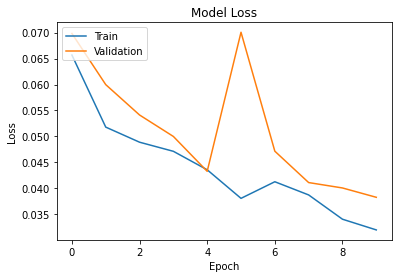

In [25]:
# have a look at the training
plt.plot(autoencoder_history.history['loss'])
plt.plot(autoencoder_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
autoencoder.save("autoencoderv_1.h5")

In [26]:
# extract the features from the autoencoder
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [28]:
encoder_output = autoencoder.get_layer("dense_3").output
encoder = Model(inputs = autoencoder.input, outputs = encoder_output)
encoded_data_train = encoder.predict(X_train)
encoded_data_val = encoder.predict(X_val)

In [29]:
#use only the representation of the autoencoder as input
model = svm_model(encoded_data_train, y_train, encoded_data_val, y_val)

Accuracy: 0.26
[[4 0 3 2 1]
 [2 2 1 4 1]
 [6 1 1 1 1]
 [1 2 1 5 1]
 [1 2 4 2 1]]


We see that the autoencoder is not able to capture a good representation on its own. Seems like, we do not have enough data for that. Now let's combine both representations PCA and autoencoder.

In [30]:
# we will merge the two representations
encoded_pca_train = []
encoded_pca_val = []

for i in range(len(encoded_data_train)):
    encoded_pca_train.append(np.concatenate((encoded_data_train[i], X_train_pca[i]), axis=None))
for i in range(len(encoded_data_val)):
    encoded_pca_val.append(np.concatenate((encoded_data_val[i], X_val_pca[i]), axis=None))
encoded_pca_train = np.array(encoded_pca_train)
encoded_pca_val = np.array(encoded_pca_val)

In [31]:
print(len(encoded_pca_train))
print(len(encoded_pca_val))

201
50


In [32]:
#use only the representation of the autoencoder as input
model = svm_model(encoded_pca_train, y_train, encoded_pca_val, y_val)

Accuracy: 0.34
[[4 1 1 4 0]
 [1 1 1 7 0]
 [1 0 1 7 1]
 [0 0 2 8 0]
 [0 1 4 2 3]]


We see that it does not increase our information to get further information from the autoencoder. It seems like we do not have enough training for these features to be meaningful. Now lets try this approach for our with augmented images enhanced set.

### III.II Enhanced Dataset

We will first us PCA and autoencoders reduce the dimensions and extract only meaningful features.

In [33]:
# first flatten the data again
X_train_flat = [x.flatten() for x in X_train_enhanced]
X_val_flat = [x.flatten() for x in X_val]

In [34]:
#we will use PCA to extract the features that explain at least 80 percent of the variance
pca = PCA(n_components=0.9, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_flat)
#use pca also on validation set, but withput further fitting
X_val_pca = pca.transform(X_val_flat)

In [35]:
print(len(X_train_pca[0]))
print(len(X_train[0]))

153
224


In [36]:
model = svm_model(X_train_pca, y_train_enhanced, X_val_pca, y_val)

Accuracy: 0.36
[[4 0 2 4 0]
 [3 2 0 5 0]
 [1 4 2 2 1]
 [1 2 1 6 0]
 [0 2 3 1 4]]


We see that we get better results with 90% variance, although, we could not reduce the feature space as much, as in the smaller set. But that was to be expected, as we now have a richer set of features.

### Autoencoder

We will use the version of the network presented in the exercise, as the dimensions fit perfectly. The autoencoder gets the same data as input and output, cause we want to learn a meaningful representation of the data.

In [37]:
autoencoder = Sequential()
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape = (224,224,3)))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape = (224,224,3)))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Flatten())
autoencoder.add(Dense(256, activation="relu"))
autoencoder.add(Dense(64, activation="relu")) #end of the encoding part
autoencoder.add(Dense(256, activation="relu")) #start of the decoding part
autoencoder.add(Dense(np.prod((14,14,128)), activation='linear'))
autoencoder.add(Reshape((14, 14, 128)))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

In [38]:
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder_history = autoencoder.fit(X_train_enhanced, X_train_enhanced, batch_size=64,epochs=10,verbose=1,validation_data=(X_val, X_val))

Epoch 1/10
16/16 [==============================] - 212s 13s/step - loss: 0.0554 - val_loss: 0.0567
Epoch 2/10
16/16 [==============================] - 193s 12s/step - loss: 0.0461 - val_loss: 0.0490
Epoch 3/10
16/16 [==============================] - 195s 12s/step - loss: 0.0386 - val_loss: 0.0435
Epoch 4/10
16/16 [==============================] - 201s 13s/step - loss: 0.0322 - val_loss: 0.0378
Epoch 5/10
16/16 [==============================] - 205s 13s/step - loss: 0.0340 - val_loss: 0.0407
Epoch 6/10
16/16 [==============================] - 218s 14s/step - loss: 0.0311 - val_loss: 0.0353
Epoch 7/10
16/16 [==============================] - 213s 13s/step - loss: 0.0275 - val_loss: 0.0339
Epoch 8/10
16/16 [==============================] - 203s 13s/step - loss: 0.0256 - val_loss: 0.0331
Epoch 9/10
16/16 [==============================] - 192s 12s/step - loss: 0.0244 - val_loss: 0.0311
Epoch 10/10
16/16 [==============================] - 180s 11s/step - loss: 0.0228 - val_loss: 0.0305

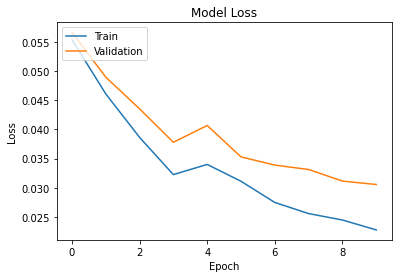

In [39]:
# have a look at the training
plt.plot(autoencoder_history.history['loss'])
plt.plot(autoencoder_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
autoencoder.save("autoencoder_enhanced_v1.h5")

In [40]:
# extract the features from the autoencoder
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 128)      

In [42]:
encoder_output = autoencoder.get_layer("dense_7").output
encoder = Model(inputs = autoencoder.input, outputs = encoder_output)
encoded_data_train = encoder.predict(X_train_enhanced)
encoded_data_val = encoder.predict(X_val)

In [43]:
#use only the representation of the autoencoder as input
model = svm_model(encoded_data_train, y_train_enhanced, encoded_data_val, y_val)

Accuracy: 0.5
[[4 1 3 2 0]
 [5 2 0 2 1]
 [1 0 8 0 1]
 [1 1 2 6 0]
 [0 3 2 0 5]]


We see that the autoencoder is now more able to capture a representation on its own. So, it seems that with more data, the encoder performs better, as expected. Now let's combine both representations PCA and autoencoder.

In [44]:
# we will merge the two representations
encoded_pca_train = []
encoded_pca_val = []

for i in range(len(encoded_data_train)):
    encoded_pca_train.append(np.concatenate((encoded_data_train[i], X_train_pca[i]), axis=None))
for i in range(len(encoded_data_val)):
    encoded_pca_val.append(np.concatenate((encoded_data_val[i], X_val_pca[i]), axis=None))
encoded_pca_train = np.array(encoded_pca_train)
encoded_pca_val = np.array(encoded_pca_val)

In [45]:
print(len(encoded_pca_train))
print(len(encoded_pca_val))

1005
50


In [46]:
#use only the representation of the autoencoder as input
model = svm_model(encoded_pca_train, y_train_enhanced, encoded_pca_val, y_val)

Accuracy: 0.36
[[4 0 2 4 0]
 [3 2 0 5 0]
 [1 4 2 2 1]
 [1 2 1 6 0]
 [0 2 3 1 4]]


We can see that the model gets better and performs in the same way as the baseline with only part of the data. It seems that for our amount of data the autoencoder with the enhanced dataset is the better choice. 

## III.3 Grey scale

In a next step we will try out the pca reduced settings with the pictures in grey and see if that will improve our model.

In [54]:
#import the data with predefined function
def load_images_gray(dir_path, labels, X, y):
    for s in labels:
        comp_path = dir_path+s+"/"
        list_of_images = os.listdir(comp_path)
        for i in list_of_images:
            img = image.load_img(dir_path+s+"/"+i, target_size=(224,224,3))
            img = img.convert('L')
            img = image.img_to_array(img)
            img = img/255
            X.append(img)
            y.append(s)

    X = np.array(X)
    return X, y

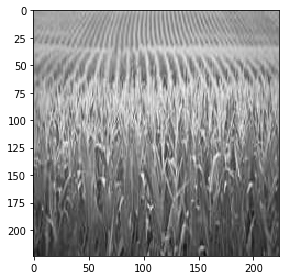

In [56]:
#Load on example picture of maize
path = "../../src/data/Abgabe_1_Crop_images/crop_images/maize/maize001a.jpeg"
image_grey = imread(path,as_gray=True)
imshow(image_grey)

In [57]:
X_train = []
y_train = []
dir_path ='../../src/data/Abgabe_1_Crop_images/crop_images/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']

X_train, y_train = load_images_gray(dir_path, labels, X_train, y_train)

X_val = []
y_val = []
dir_path_val = '../../src/data/Abgabe_1_Crop_images/some_more_images/'
labels_val = ["jute", "maize", "rice",'sugarcane','wheat']

X_val, y_val = load_images_gray(dir_path_val, labels_val, X_val, y_val)

print("I'm done!")

I'm done!


In [58]:
X_train_augmented = []
y_train_augmented = []
dir_path ='../../src/data/Abgabe_1_Crop_images/kag2/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_train_augmented, y_train_augmented = load_images_gray(dir_path, labels, X_train_augmented, y_train_augmented)

print("I'm done!")

I'm done!


In [59]:
#Construct a new training set containing both normal and augmetented 
X_train_enhanced = np.concatenate((X_train, X_train_augmented))
y_train_enhanced = np.concatenate((y_train, y_train_augmented))

In [60]:
# first flatten the data again
X_train_flat = [x.flatten() for x in X_train_enhanced]
X_val_flat = [x.flatten() for x in X_val]

In [61]:
#we will use PCA to extract the features that explain at least 80 percent of the variance
pca = PCA(n_components=0.9, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_flat)
#use pca also on validation set, but withput further fitting
X_val_pca = pca.transform(X_val_flat)

In [62]:
print(len(X_train_pca[0]))
print(len(X_train[0]))

164
224


In [63]:
model = svm_model(X_train_pca, y_train_enhanced, X_val_pca, y_val)

Accuracy: 0.26
[[3 1 4 2 0]
 [2 1 2 3 2]
 [0 3 2 4 1]
 [1 1 4 4 0]
 [1 0 5 1 3]]


We see that grey-scaling makes the model a lot worse, as it seems that it is less able to distinguish the crop then.

As the results for the SVM we see that the best modelis by  around 10% worse than the first result of VGG. Therefore, we will not try extensive hyperparameter tuning and will focus on CNNs and transfer learning in the following.

## IV. CNNs

To not get confused, we will reload the enhanced dataset here again.

In [64]:
def load_images(dir_path, labels, X, y, image_size):
    for s in labels:
        comp_path = dir_path+s+"/"
        list_of_images = os.listdir(comp_path)
        for i in list_of_images:
            img = image.load_img(dir_path+s+"/"+i, target_size=image_size)
            img = image.img_to_array(img)
            img = img/255
            X.append(img)
            y.append(s)

    X = np.array(X)
    return X, y

In [65]:
# function to evaluate the model
def evaluate_model(m, X, y):
    y_pred = m.predict(X)
    predicted_classes = np.argmax(y_pred,axis=1)
    
    predictions = []
    for i in predicted_classes:
        if i == 0:
            predictions.append("jute")
        elif i == 1:
            predictions.append("maize")
        elif i == 2:
            predictions.append("rice")
        elif i == 3:
            predictions.append("sugarcane")
        else:
            predictions.append("wheat")
    print("Accuracy:",metrics.accuracy_score(y, predictions))
    print(confusion_matrix(y, predictions))
    

In [66]:
X_train = []
y_train = []
dir_path ='../../src/data/Abgabe_1_Crop_images/crop_images/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_train, y_train = load_images(dir_path, labels, X_train, y_train, image_size)

X_val = []
y_val = []
dir_path_val = '../../src/data/Abgabe_1_Crop_images/some_more_images/'
labels_val = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_val, y_val = load_images(dir_path_val, labels_val, X_val, y_val, image_size)

print("I'm done!")

I'm done!


In [67]:
X_train_augmented = []
y_train_augmented = []
dir_path ='../../src/data/Abgabe_1_Crop_images/kag2/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_train_augmented, y_train_augmented = load_images(dir_path, labels, X_train_augmented, y_train_augmented, image_size)

print("I'm done!")

I'm done!


In [68]:
#Construct a new training set containing both normal and augmetented 
X_train_enhanced = np.concatenate((X_train, X_train_augmented))
y_train_enhanced = np.concatenate((y_train, y_train_augmented))

In [69]:
y_train_res = asarray(y_train_enhanced).reshape(-1, 1)
y_val_res = asarray(y_val).reshape(-1, 1)

oh_enc = OneHotEncoder(sparse=False)

y_train_onehot = oh_enc.fit_transform(y_train_res)
y_val_onehot = oh_enc.transform(y_val_res)

print("Original Label:", y_train[0])
print("One-Hot Label:", y_train_onehot[0])

Original Label: jute
One-Hot Label: [1. 0. 0. 0. 0.]


In [70]:
# use the predefined model from the exercise for initialisation and change only the last layer, as we have 5 classes
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (224,224,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(1024,activation="relu"),      
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512,activation ="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation ="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5,activation = "softmax")  
])

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 128)      

In [72]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
# we will focus on the val_accuracy instead of the loss as early stopping criterion, as the accuracy can increase although the loss does not get better
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)
history = model.fit(X_train_enhanced, y_train_onehot, batch_size=32,epochs=20,verbose=1,validation_data=(X_val, y_val_onehot), callbacks=[callback])

Epoch 1/20
32/32 [==============================] - 51s 2s/step - loss: 1.6073 - accuracy: 0.2139 - val_loss: 1.6069 - val_accuracy: 0.1800
Epoch 2/20
32/32 [==============================] - 49s 2s/step - loss: 1.5654 - accuracy: 0.2766 - val_loss: 1.5682 - val_accuracy: 0.2400
Epoch 3/20
32/32 [==============================] - 38s 1s/step - loss: 1.3943 - accuracy: 0.3920 - val_loss: 1.4664 - val_accuracy: 0.3400
Epoch 4/20
32/32 [==============================] - 35s 1s/step - loss: 1.2166 - accuracy: 0.4995 - val_loss: 1.3368 - val_accuracy: 0.4200
Epoch 5/20
32/32 [==============================] - 35s 1s/step - loss: 0.9829 - accuracy: 0.6259 - val_loss: 1.3779 - val_accuracy: 0.4200
Epoch 6/20
32/32 [==============================] - 38s 1s/step - loss: 0.7878 - accuracy: 0.7095 - val_loss: 1.9279 - val_accuracy: 0.5000
Epoch 7/20
32/32 [==============================] - 33s 1s/step - loss: 0.6386 - accuracy: 0.7891 - val_loss: 2.3183 - val_accuracy: 0.5200
Epoch 8/20
32/32 [==

We clearly see that at some point the model totally overfits on the train data. It seems like in the end, we do not have enough data to efficiently train a CNN. But that was also to be expected, as our training set contains only 200 images per class. So, we also discard the CNN approach and focus on transfer learning, as it already achieved better results as a baseline than the other methods.

In [74]:
model.save("CNN_v1.h5")
model = load_model("CNN_v1.h5")

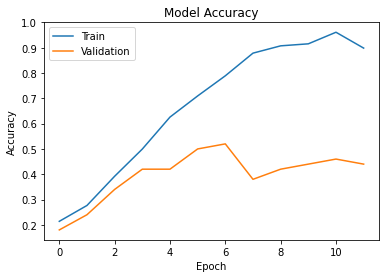

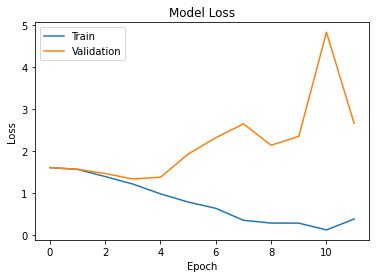

In [75]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [76]:
evaluate_model(model, X_val, y_val)

Accuracy: 0.52
[[3 3 2 1 1]
 [0 5 0 5 0]
 [0 7 3 0 0]
 [0 0 2 8 0]
 [0 1 1 1 7]]


As our datasize is restricted and the approach of VGG via transfer learning is still better in a pretty simple form, we will not try to extensively train a CNN in different settings and focus on two different pre trained transfer learning models for image classification. VGG and inception v3 and will try the same amount of added layers on top.

## V. Transfer Learning

### V.I VGG

We will use again the pre-trained VGG network, but with a more enhanced network structure with VGG19 consiting of 19 layers and see if we are able to achieve better results. VGG-19 is a trained Convolutional Neural Network, from the Visual Geometry Group of the Department of Engineering Science at the University of Oxford. To be able to use the labels in a neural network, we need to one hot encode them first.

In [77]:
# one hot encode the labels with augmented pictures
y_val_res = asarray(y_val).reshape(-1, 1)
y_train_res_enhanced = asarray(y_train_enhanced).reshape(-1, 1)


oh_enc = OneHotEncoder(sparse=False)

y_train_onehot_augmented_enhanced = oh_enc.fit_transform(y_train_res_enhanced)
y_val_onehot_augmented = oh_enc.transform(y_val_res)

print("Original Label:", y_train[0])
print("One-Hot Label:", y_train_onehot[0])

Original Label: jute
One-Hot Label: [1. 0. 0. 0. 0.]


Initialise the model with 2 or 3 new dense layers on top respectively.

In [120]:
# use the variant withput further training and Leave out the last fully connected layer
vgg19_without_top_layer = VGG19(include_top=False, input_shape=(224, 224, 3))
vgg19_without_top_layer.trainable = False

# Flatten the output layer to 1 dimension to be able to build on top of it
flat = Flatten()(vgg16_without_top_layer.layers[-1].output)
dense1 = Dense(256, activation="relu")(flat)
drop1 = tf.keras.layers.Dropout(0.4)(dense1)
dense2 = Dense(128, activation="relu")(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(dense2)
#adjust the ouptut layer to 5 classes
output = Dense(5, activation="softmax")(drop2)

model_transfer_learning = Model(inputs = vgg16_without_top_layer.inputs, outputs = output)
model_transfer_learning.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [121]:
#compile the model
model_transfer_learning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#callback for early stopping and will also monitor the validation accuracy instead of the loss
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)

In [122]:
#higher batch size for our augmented set
model_transfer_learning_history = model_transfer_learning.fit(X_train_enhanced, y_train_onehot_augmented_enhanced, batch_size=32,epochs=15,verbose=1,validation_data=(X_val, y_val_onehot_augmented), callbacks=[callback])

Epoch 1/15
32/32 [==============================] - 716s 22s/step - loss: 1.9700 - accuracy: 0.3294 - val_loss: 1.4870 - val_accuracy: 0.4000
Epoch 2/15
32/32 [==============================] - 687s 21s/step - loss: 1.1438 - accuracy: 0.5313 - val_loss: 1.2234 - val_accuracy: 0.4600
Epoch 3/15
32/32 [==============================] - 613s 19s/step - loss: 0.7863 - accuracy: 0.6856 - val_loss: 1.2327 - val_accuracy: 0.4800
Epoch 4/15
32/32 [==============================] - 649s 20s/step - loss: 0.6244 - accuracy: 0.7791 - val_loss: 1.2793 - val_accuracy: 0.5200
Epoch 5/15
32/32 [==============================] - 601s 19s/step - loss: 0.4317 - accuracy: 0.8368 - val_loss: 1.1934 - val_accuracy: 0.6000
Epoch 6/15
32/32 [==============================] - 642s 20s/step - loss: 0.3673 - accuracy: 0.8647 - val_loss: 1.1100 - val_accuracy: 0.6400
Epoch 7/15
32/32 [==============================] - 630s 20s/step - loss: 0.2723 - accuracy: 0.9095 - val_loss: 1.4009 - val_accuracy: 0.5400
Epoch 

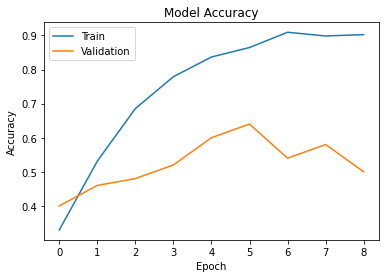

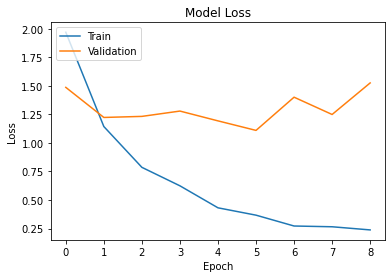

In [123]:
# Accuracy
plt.plot(model_transfer_learning_history.history['accuracy'])
plt.plot(model_transfer_learning_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(model_transfer_learning_history.history['loss'])
plt.plot(model_transfer_learning_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [124]:
evaluate_model(model_transfer_learning, X_val, y_val)

Accuracy: 0.64
[[9 0 1 0 0]
 [2 7 0 1 0]
 [0 5 3 2 0]
 [1 2 1 6 0]
 [0 2 1 0 7]]


In [125]:
model_transfer_learning.save("Transfer_vgg19_v2.h5")
model = load_model("Transfer_vgg19_v2.h5")

### V.II Inception v3

We will use again a pre-trained network. This time it is called inception_v3. It is the third edition of Google's Inception Convolutional Neural Network for image analysis and object detection. The design of Inceptionv3 intends to allow deeper networks without letting the number of parameters explode.

In [126]:
#Leave out the last fully connected layer
inceptionv3_without_top_layer = InceptionV3(include_top=False, input_shape=(224, 224, 3))
inceptionv3_without_top_layer.trainable = False

In [127]:
# Flatten the output layer to 1 dimension to be able to build on top of it
flat = Flatten()(inceptionv3_without_top_layer.layers[-1].output)
dense1 = Dense(256, activation="relu")(flat)
drop1 = tf.keras.layers.Dropout(0.4)(dense1)
dense2 = Dense(128, activation="relu")(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(dense2)
#adjust the ouptut layer to 5 classes
output = Dense(5, activation="softmax")(drop2)

model_transfer_learning = Model(inputs = inceptionv3_without_top_layer.inputs, outputs = output)
model_transfer_learning.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_120[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________

In [128]:
#compile the model
model_transfer_learning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#callback for early stopping and will also monitor the validation accuracy instead of the loss
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)

In [129]:
#higher batch size for our augmented set
model_transfer_learning_history = model_transfer_learning.fit(X_train_enhanced, y_train_onehot_augmented_enhanced, batch_size=32,epochs=15,verbose=1,validation_data=(X_val, y_val_onehot_augmented), callbacks=[callback])

Epoch 1/15
32/32 [==============================] - 101s 3s/step - loss: 5.3736 - accuracy: 0.4070 - val_loss: 1.9025 - val_accuracy: 0.1800
Epoch 2/15
32/32 [==============================] - 110s 3s/step - loss: 0.9598 - accuracy: 0.6706 - val_loss: 1.6290 - val_accuracy: 0.4000
Epoch 3/15
32/32 [==============================] - 104s 3s/step - loss: 0.6964 - accuracy: 0.7522 - val_loss: 1.7062 - val_accuracy: 0.4000
Epoch 4/15
32/32 [==============================] - 89s 3s/step - loss: 0.5351 - accuracy: 0.8209 - val_loss: 2.1179 - val_accuracy: 0.4400
Epoch 5/15
32/32 [==============================] - 92s 3s/step - loss: 0.4036 - accuracy: 0.8557 - val_loss: 2.1002 - val_accuracy: 0.4000
Epoch 6/15
32/32 [==============================] - 99s 3s/step - loss: 0.3703 - accuracy: 0.8756 - val_loss: 1.7832 - val_accuracy: 0.4800
Epoch 7/15
32/32 [==============================] - 92s 3s/step - loss: 0.3879 - accuracy: 0.8607 - val_loss: 1.8136 - val_accuracy: 0.5200
Epoch 8/15
32/32 

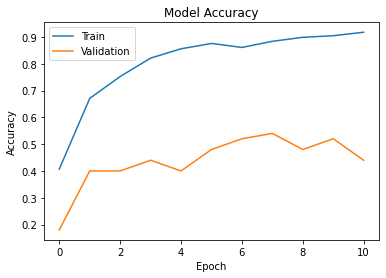

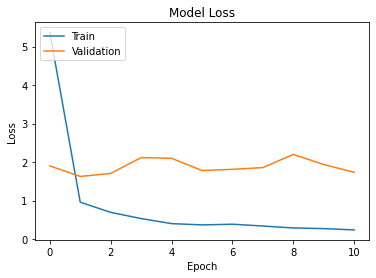

In [130]:
# Accuracy
plt.plot(model_transfer_learning_history.history['accuracy'])
plt.plot(model_transfer_learning_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(model_transfer_learning_history.history['loss'])
plt.plot(model_transfer_learning_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [131]:
evaluate_model(model_transfer_learning, X_val, y_val)

Accuracy: 0.54
[[7 0 2 0 1]
 [0 6 1 2 1]
 [0 0 3 2 5]
 [0 3 0 3 4]
 [0 1 0 1 8]]


In [132]:
model_transfer_learning.save("Transfer_inception_v2.h5")
model = load_model("Transfer_inception_v2.h5")

### V.III ResNet50

At last, we will try out ResNet50. ResNet stands for Residual Network. It is an  neural network architecture with 50 layers  that was first introduced by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in 2015. So its far bigger, than the two earlier models.

In [182]:
#Leave out the last fully connected layer
resnet_without_top_layer = ResNet50(include_top=False, input_shape=(224, 224, 3))
resnet_without_top_layer.trainable = False

In [187]:
# Flatten the output layer to 1 dimension to be able to build on top of it
flat = Flatten()(resnet_without_top_layer.layers[-1].output)
dense1 = Dense(256, activation="relu")(flat)
#adjust the ouptut layer to 5 classes
output = Dense(5, activation="softmax")(drop2)

model_transfer_learning = Model(inputs = resnet_without_top_layer.inputs, outputs = output)
model_transfer_learning.summary()

Model: "functional_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [188]:
#compile the model
model_transfer_learning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#callback for early stopping and will also monitor the validation accuracy instead of the loss
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights = True)

In [189]:
#higher batch size for our augmented set
model_transfer_learning_history = model_transfer_learning.fit(X_train_enhanced, y_train_onehot_augmented_enhanced, batch_size=16,epochs=15,verbose=1,validation_data=(X_val, y_val_onehot_augmented), callbacks=[callback])

Epoch 1/15
32/32 [==============================] - 120s 4s/step - loss: 4.6191 - accuracy: 0.2109 - val_loss: 1.6061 - val_accuracy: 0.2800
Epoch 2/15
32/32 [==============================] - 149s 5s/step - loss: 1.7913 - accuracy: 0.2338 - val_loss: 1.5455 - val_accuracy: 0.2800
Epoch 3/15
32/32 [==============================] - 148s 5s/step - loss: 1.6100 - accuracy: 0.2498 - val_loss: 1.6010 - val_accuracy: 0.2400
Epoch 4/15
18/32 [===============>..............] - ETA: 1:01 - loss: 1.6017 - accuracy: 0.2153

KeyboardInterrupt: 

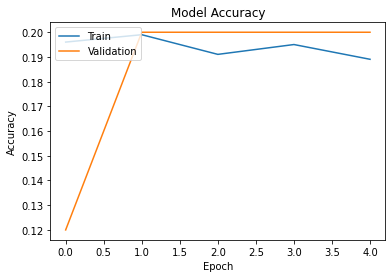

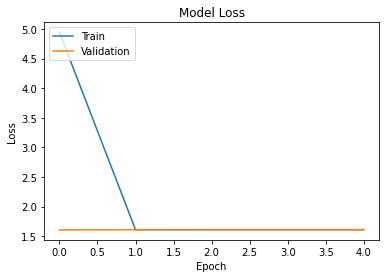

In [143]:
# Accuracy
plt.plot(model_transfer_learning_history.history['accuracy'])
plt.plot(model_transfer_learning_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(model_transfer_learning_history.history['loss'])
plt.plot(model_transfer_learning_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [144]:
evaluate_model(model_transfer_learning, X_val, y_val)

Accuracy: 0.2
[[ 0 10  0  0  0]
 [ 0 10  0  0  0]
 [ 0 10  0  0  0]
 [ 0 10  0  0  0]
 [ 0 10  0  0  0]]


In [145]:
model_transfer_learning.save("resnet_v1.h5")
model = load_model("resnet_v1.h5")

Due to limited computation power, we will not exhaust every single parameter of those models. But we can clearly see that with out dataset the pretrained models perform best. In particular, VGG19 and VGG16 outperform the other models. Inception is a bit worse than the VGG16 baseline. 


### V.IV Voting ensemble

We see in the confusion matrices, that the models have different tendencies. In a last step, we want to see if a combination of the models by voting will improve our results. We will also load the CNN again for that.

In [159]:
#load different models into one list
model_vgg = load_model("Transfer_vgg19_v2.h5")
model_inception = load_model("Transfer_inception_v2.h5")
model_CNN = load_model("CNN_v1.h5")

model_list =[model_vgg, model_inception, model_CNN]

In [168]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, X_test):
    # make predictions
    yhats = [model.predict(X_test) for model in members]
    yhats = np.array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    print(summed)
    # argmax across classes
    predictions = argmax(summed, axis=1)
    return predictions

In [165]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, X_test, y):
    # make prediction
    predictions = ensemble_predictions(members, X_test)
    # calculate accuracy
    print("Accuracy:",metrics.accuracy_score(y, predictions))
    print(confusion_matrix(y, predictions))

In [169]:
# make evaluation
evaluate_n_members(model_list, X_val, y_val)

[[6.8500580e-11 1.0000000e+00 6.6585308e-03 1.0000067e+00 9.9333477e-01]
 [5.9068091e-11 1.0000000e+00 6.3370466e-03 1.0000058e+00 9.9365705e-01]
 [5.7534002e-11 1.0000000e+00 6.0445513e-03 1.0000056e+00 9.9394989e-01]
 [4.5360337e-11 1.0000000e+00 4.9991696e-03 1.0000043e+00 9.9499655e-01]
 [8.0614730e-11 1.0000000e+00 7.6451264e-03 1.0000074e+00 9.9234748e-01]
 [1.0567878e-10 1.0000000e+00 8.5457098e-03 1.0000098e+00 9.9144453e-01]
 [7.4711522e-11 1.0000000e+00 6.9268355e-03 1.0000072e+00 9.9306595e-01]
 [4.8220181e-11 1.0000000e+00 5.1375972e-03 1.0000049e+00 9.9485755e-01]
 [5.5186616e-11 1.0000000e+00 6.1178901e-03 1.0000054e+00 9.9387676e-01]
 [7.2143805e-11 1.0000000e+00 7.0197461e-03 1.0000069e+00 9.9297333e-01]
 [7.8223698e-11 1.0000000e+00 7.0462632e-03 1.0000073e+00 9.9294645e-01]
 [4.0707278e-11 1.0000000e+00 4.8102057e-03 1.0000041e+00 9.9518579e-01]
 [6.1837119e-11 1.0000000e+00 6.1793569e-03 1.0000060e+00 9.9381471e-01]
 [6.4004260e-11 1.0000000e+00 6.7069065e-03 1.00000

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\metrics\_classification.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


ValueError: Mix of label input types (string and number)

## VI. Test set

In the last part we will evaluate our models on our given test set and see how they behave. We will have a look at the confusion matrices and point out where the models are not able to distinguish the classes.

In [203]:
X_test = []
y_test = []
dir_path_test = '../../src/data/Abgabe_1_Crop_images/test_crop_image/'
labels_test = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_test, y_test = load_images(dir_path_test, labels_val, X_test, y_test, image_size)

print("I'm done!")

I'm done!


Text(0.5, 1.0, 'Overview test set')

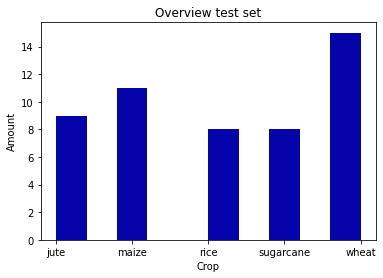

In [204]:
plt.hist(x=y_test, color='#0504aa', bins=5 )
plt.xlabel('Crop')
plt.ylabel('Amount')
plt.title('Overview test set')

In [205]:
model = load_model("Transfer_vgg16_baseline_v1.h5")

In [206]:
evaluate_model(model, X_test, y_test)

Accuracy: 0.5098039215686274
[[5 2 2 0 0]
 [0 8 3 0 0]
 [2 1 5 0 0]
 [1 5 1 1 0]
 [1 2 5 0 7]]


In [207]:
model = load_model("Transfer_vgg19_v2.h5")

In [208]:
evaluate_model(model, X_test, y_test)

Accuracy: 0.5686274509803921
[[8 0 1 0 0]
 [1 7 1 0 2]
 [1 2 5 0 0]
 [0 4 0 3 1]
 [1 5 1 2 6]]


In [214]:
model = load_model("Transfer_inception_v2.h5")

In [216]:
evaluate_model(model, X_test, y_test)

Accuracy: 0.45098039215686275
[[ 4  3  2  0  0]
 [ 0  6  0  2  3]
 [ 0  2  1  0  5]
 [ 1  4  0  0  3]
 [ 0  2  1  0 12]]


In [211]:
model = load_model("resnet_v1.h5")

In [212]:
evaluate_model(model, X_test, y_test)

Accuracy: 0.19607843137254902
[[ 0  9  0  0  0]
 [ 0 10  0  0  1]
 [ 0  8  0  0  0]
 [ 1  6  1  0  0]
 [ 0 15  0  0  0]]


We can see that it has problems distinguishing between (look at pictures), let models vote.

## VII. Outlook

At last, we will give an outlook on possible next steps and improvement opportunities.

* As we have only a small dataset, the first possibility that comes into mind for improving the model, is clearly enhancing the dataset with more pictures to give the algorithms more material to learn.
* Due to limited computation power on CPU and next possible step is using GPU and perform exhaustive hyperparameter tuning.
* Use ensemble methods to combine the power of the algorithms by for example voting.
* Increase the size of the validation set to empower the algorithm during the training phase.
* Try further transfer learning models like ResNet50 or Elastic Net B7.